# Plotting level sets

The goal is to plot the level set evolution for the neural ODEs with standard and robust training

In [122]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import numpy as np



# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

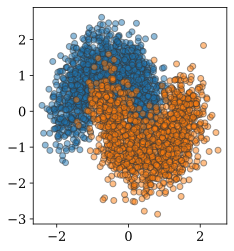

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler

from torch.utils import data as data
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(data_type, batch_size = 3000, noise = 0.15, factor = 0.15, random_state = 1, shuffle = False):
    if data_type == 'circles':
        X, y = make_circles(batch_size, noise=noise, factor=factor, random_state=random_state, shuffle = shuffle)
        
        
    elif data_type == 'blobs':
        centers = [[-1, -1], [1, 1]]
        X, y = make_blobs(
    n_samples=batch_size, centers=centers, cluster_std=noise, random_state=0)
        
        
    elif data_type == 'moons':
        X, y = make_moons(batch_size, noise = noise, shuffle = shuffle , random_state = 0)
    
    
    elif data_type == 'xor':
        X = torch.randint(low=0, high=2, size=(batch_size, 2), dtype=torch.float32)
        y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).float()
        # y = y.to(torch.int64)
        X += noise * torch.randn(X.shape)
        
        
    else: 
        print('datatype not supported')
        return None, None

    g = torch.Generator()
    g.manual_seed(random_state)
    
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05 ) #random_state=2, shuffle = shuffle)

    X_train = torch.Tensor(X_train) # transform to torch tensor for dataloader
    y_train = torch.Tensor(y_train) #transform to torch tensor for dataloader

    X_test = torch.Tensor(X_test) # transform to torch tensor for dataloader
    y_test = torch.Tensor(y_test) #transform to torch tensor for dataloader

    X_train = X_train.type(torch.float32)  #type of orginial pickle.load data
    y_train = y_train.type(torch.int64) #dtype of original picle.load data

    X_test = X_test.type(torch.float32)  #type of orginial pickle.load data
    y_test = y_test.type(torch.int64) #dtype of original picle.load data


    train_data = TensorDataset(X_train,y_train) # create your datset
    test_data = TensorDataset(X_test, y_test)

    train = DataLoader(train_data, batch_size=64, shuffle=shuffle, generator=g)
    test = DataLoader(test_data, batch_size=256, shuffle=shuffle, generator = g) #128 before
    
    data_0 = X_train[y_train == 0]
    data_1 = X_train[y_train == 1]
    fig = plt.figure()
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333",  alpha = 0.5) #color = 'crimson',
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", alpha = 0.5) #color = 'dodgerblue'
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.savefig('trainingset.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
    plt.show()
    
    return train, test


data_noise = 0.3
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise)



#Visualizing the data


In [124]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 1.5808, -0.9445],
        [-0.8312,  1.5890],
        [ 0.3675, -1.5283],
        [-0.5831,  0.3875],
        [ 0.9361, -1.1971],
        [ 1.4920, -1.0327],
        [-0.1781, -0.1677],
        [ 0.9890, -1.4818],
        [ 1.3730, -1.2606],
        [-0.7484,  2.6198]]) tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 0])


# Model dynamics

In [125]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 1

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5, 6
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False


non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

    


NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [126]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
        (5): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


## Training

In [127]:
from models.training import Trainer

num_epochs = 60 #number of optimization runs in which the dataset is used for gradient decent
trainer_anode = Trainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True) 

trainer_anode.train(dataloader, num_epochs)

/Users/Tobi/FAUbox/Python/borjan dynamical.systems/models/training.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softpred = m(y_pred)



Epoch 0/45
Loss: 0.896
Accuracy: 0.406

Epoch 10/45
Loss: 0.832
Accuracy: 0.422

Epoch 20/45
Loss: 0.778
Accuracy: 0.453

Epoch 30/45
Loss: 0.766
Accuracy: 0.406

Epoch 40/45
Loss: 0.710
Accuracy: 0.516
Epoch 1: 0.772

Epoch 0/45
Loss: 0.754
Accuracy: 0.500

Epoch 10/45
Loss: 0.707
Accuracy: 0.500

Epoch 20/45
Loss: 0.669
Accuracy: 0.609

Epoch 30/45
Loss: 0.674
Accuracy: 0.609

Epoch 40/45
Loss: 0.624
Accuracy: 0.672
Epoch 2: 0.670

Epoch 0/45
Loss: 0.654
Accuracy: 0.656

Epoch 10/45
Loss: 0.617
Accuracy: 0.719

Epoch 20/45
Loss: 0.589
Accuracy: 0.781

Epoch 30/45
Loss: 0.605
Accuracy: 0.750

Epoch 40/45
Loss: 0.552
Accuracy: 0.797
Epoch 3: 0.595

Epoch 0/45
Loss: 0.574
Accuracy: 0.750

Epoch 10/45
Loss: 0.544
Accuracy: 0.797

Epoch 20/45
Loss: 0.522
Accuracy: 0.781

Epoch 30/45
Loss: 0.545
Accuracy: 0.766

Epoch 40/45
Loss: 0.485
Accuracy: 0.797
Epoch 4: 0.531

Epoch 0/45
Loss: 0.504
Accuracy: 0.797

Epoch 10/45
Loss: 0.479
Accuracy: 0.828

Epoch 20/45
Loss: 0.463
Accuracy: 0.781

E

In [128]:
from models.training import doublebackTrainer

# num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0.2) 

trainer_rnode.train(dataloader, num_epochs)


Epoch 0/45
Loss: 0.896
Robust Term Loss: 0.070
Accuracy: 0.406

Epoch 10/45
Loss: 0.833
Robust Term Loss: 0.067
Accuracy: 0.422

Epoch 20/45
Loss: 0.780
Robust Term Loss: 0.064
Accuracy: 0.453

Epoch 30/45
Loss: 0.767
Robust Term Loss: 0.059
Accuracy: 0.391

Epoch 40/45
Loss: 0.712
Robust Term Loss: 0.057
Accuracy: 0.500
Epoch 1: 0.773

Epoch 0/45
Loss: 0.755
Robust Term Loss: 0.059
Accuracy: 0.500

Epoch 10/45
Loss: 0.708
Robust Term Loss: 0.056
Accuracy: 0.453

Epoch 20/45
Loss: 0.671
Robust Term Loss: 0.054
Accuracy: 0.609

Epoch 30/45
Loss: 0.674
Robust Term Loss: 0.052
Accuracy: 0.609

Epoch 40/45
Loss: 0.624
Robust Term Loss: 0.049
Accuracy: 0.688
Epoch 2: 0.671

Epoch 0/45
Loss: 0.652
Robust Term Loss: 0.052
Accuracy: 0.641

Epoch 10/45
Loss: 0.616
Robust Term Loss: 0.049
Accuracy: 0.734

Epoch 20/45
Loss: 0.589
Robust Term Loss: 0.047
Accuracy: 0.781

Epoch 30/45
Loss: 0.603
Robust Term Loss: 0.049
Accuracy: 0.750

Epoch 40/45
Loss: 0.552
Robust Term Loss: 0.047
Accuracy: 0.79

## Level Sets

Observe that the blue and red data points are getting seperated further as time passes.

In [129]:
import seaborn as sns
from matplotlib.colors import to_rgba, to_rgb
import numpy as np
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

@torch.no_grad()
def classification_evolution(model, data, label, grad = None, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2], layer = -1):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(5, 5), dpi=300)
    # plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0", zorder = 1)
    # plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1", zorder = 1)

    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)
    # plt.legend()
    if grad is not None:
        for i in range(len(data[:, 0])):
            plt.arrow(data[i, 0], data[i, 1], grad[i, 0], grad[i, 1],
                    head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5)

   
    model.to(device)
    # creates the RGB values of the two scatter plot colors.
    # c0 = torch.Tensor(to_rgba("C0")).to(device)
    # c1 = torch.Tensor(to_rgba("C1")).to(device)

    

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    
    _, proj_traj = model(model_inputs)
    
    # for i in range(inputs.shape[0]):
    #     interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        
    preds = proj_traj[layer,:,:]
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    # now we only want to have the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    # Specifying "None" in a dimension creates a new one. The rgb values hence get rescaled according to the prediction
    # output_image = (1 - preds) * c1[None, None] + preds * c0[None, None]
    # # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    # output_image = output_image.cpu().numpy()
    # plt.imshow(output_image, origin='lower', extent=(x1lower, x1upper, x2lower, x2upper), zorder = -1)
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])
    # plt.axis('scaled')

    # labels_predicted = [0 if value <= 0.5 else 1 for value in labels_predicted.numpy()]
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is black, last is red
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        plt.contourf(xx1, xx2, z, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        



    # preds_contour = preds.view(len(x1), len(x1)).detach()
    # plt.contourf(xx1, xx2, preds_contour, alpha=1)
    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # return fig

In [130]:
def comparison_plot(fig1, title1, fig2, title2, output_file, fig_size = 10, show = False):
    plt.figure(dpi = 300, figsize=(fig_size, fig_size))
    plt.subplot(121)
    sub1 = imageio.imread(fig1)
    plt.imshow(sub1)
    plt.title(title1)
    plt.axis('off')

    plt.subplot(122)
    sub2 = imageio.imread(fig2)
    plt.imshow(sub2)
    plt.title(title2)
    plt.axis('off')
    plt.savefig(output_file, bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
    if show: plt.show()
    else:
        plt.gca()
        plt.close()

In [131]:
import imageio
import os
fig_name_base = 'levelsets'
fig_name = fig_name_base + '.png'
gif_name = fig_name_base + '_comp.gif'

fig_name_base_rob = fig_name_base + '_rob'
fig_name_rob = fig_name_base_rob + '.png'


for X_viz, y_viz in dataloader_viz:
    imgs = []
    for layer in torch.arange(num_steps):
        classification_evolution(anode, X_viz, y_viz, fig_name = fig_name_base, layer = layer)
        # imgs.append(imageio.imread(fig_name))
        classification_evolution(rnode, X_viz, y_viz, fig_name = fig_name_base_rob, layer = layer)
        
        comparison_plot(fig_name, 'standard training', fig_name_rob, 'robust training', 'levelsets_comp.png')
        print(layer, ' ploted')
        
        # plt.figure(dpi = 600)
        # plt.subplot(121)
        # levelsets = imageio.imread(fig_name)
        # plt.imshow(levelsets)
        # plt.title('Standard Training')
        # plt.axis('off')

        # plt.subplot(122)
        # levelsets_rob = imageio.imread(fig_name_rob)
        # plt.imshow(levelsets_rob)
        # plt.title('Robust Training')
        # plt.axis('off')
        # plt.savefig('levelsets_comp.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        # plt.clf()
        # plt.close()
        
        imgs.append(imageio.imread('levelsets_comp.png'))
        # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
    imageio.mimwrite(gif_name, imgs, fps = 1)
    # visualize_classification(rnode, X_viz, y_viz, fig_name = 'class_test1')
    break

tensor(0)  ploted
tensor(1)  ploted
tensor(2)  ploted
tensor(3)  ploted
tensor(4)  ploted
tensor(5)  ploted


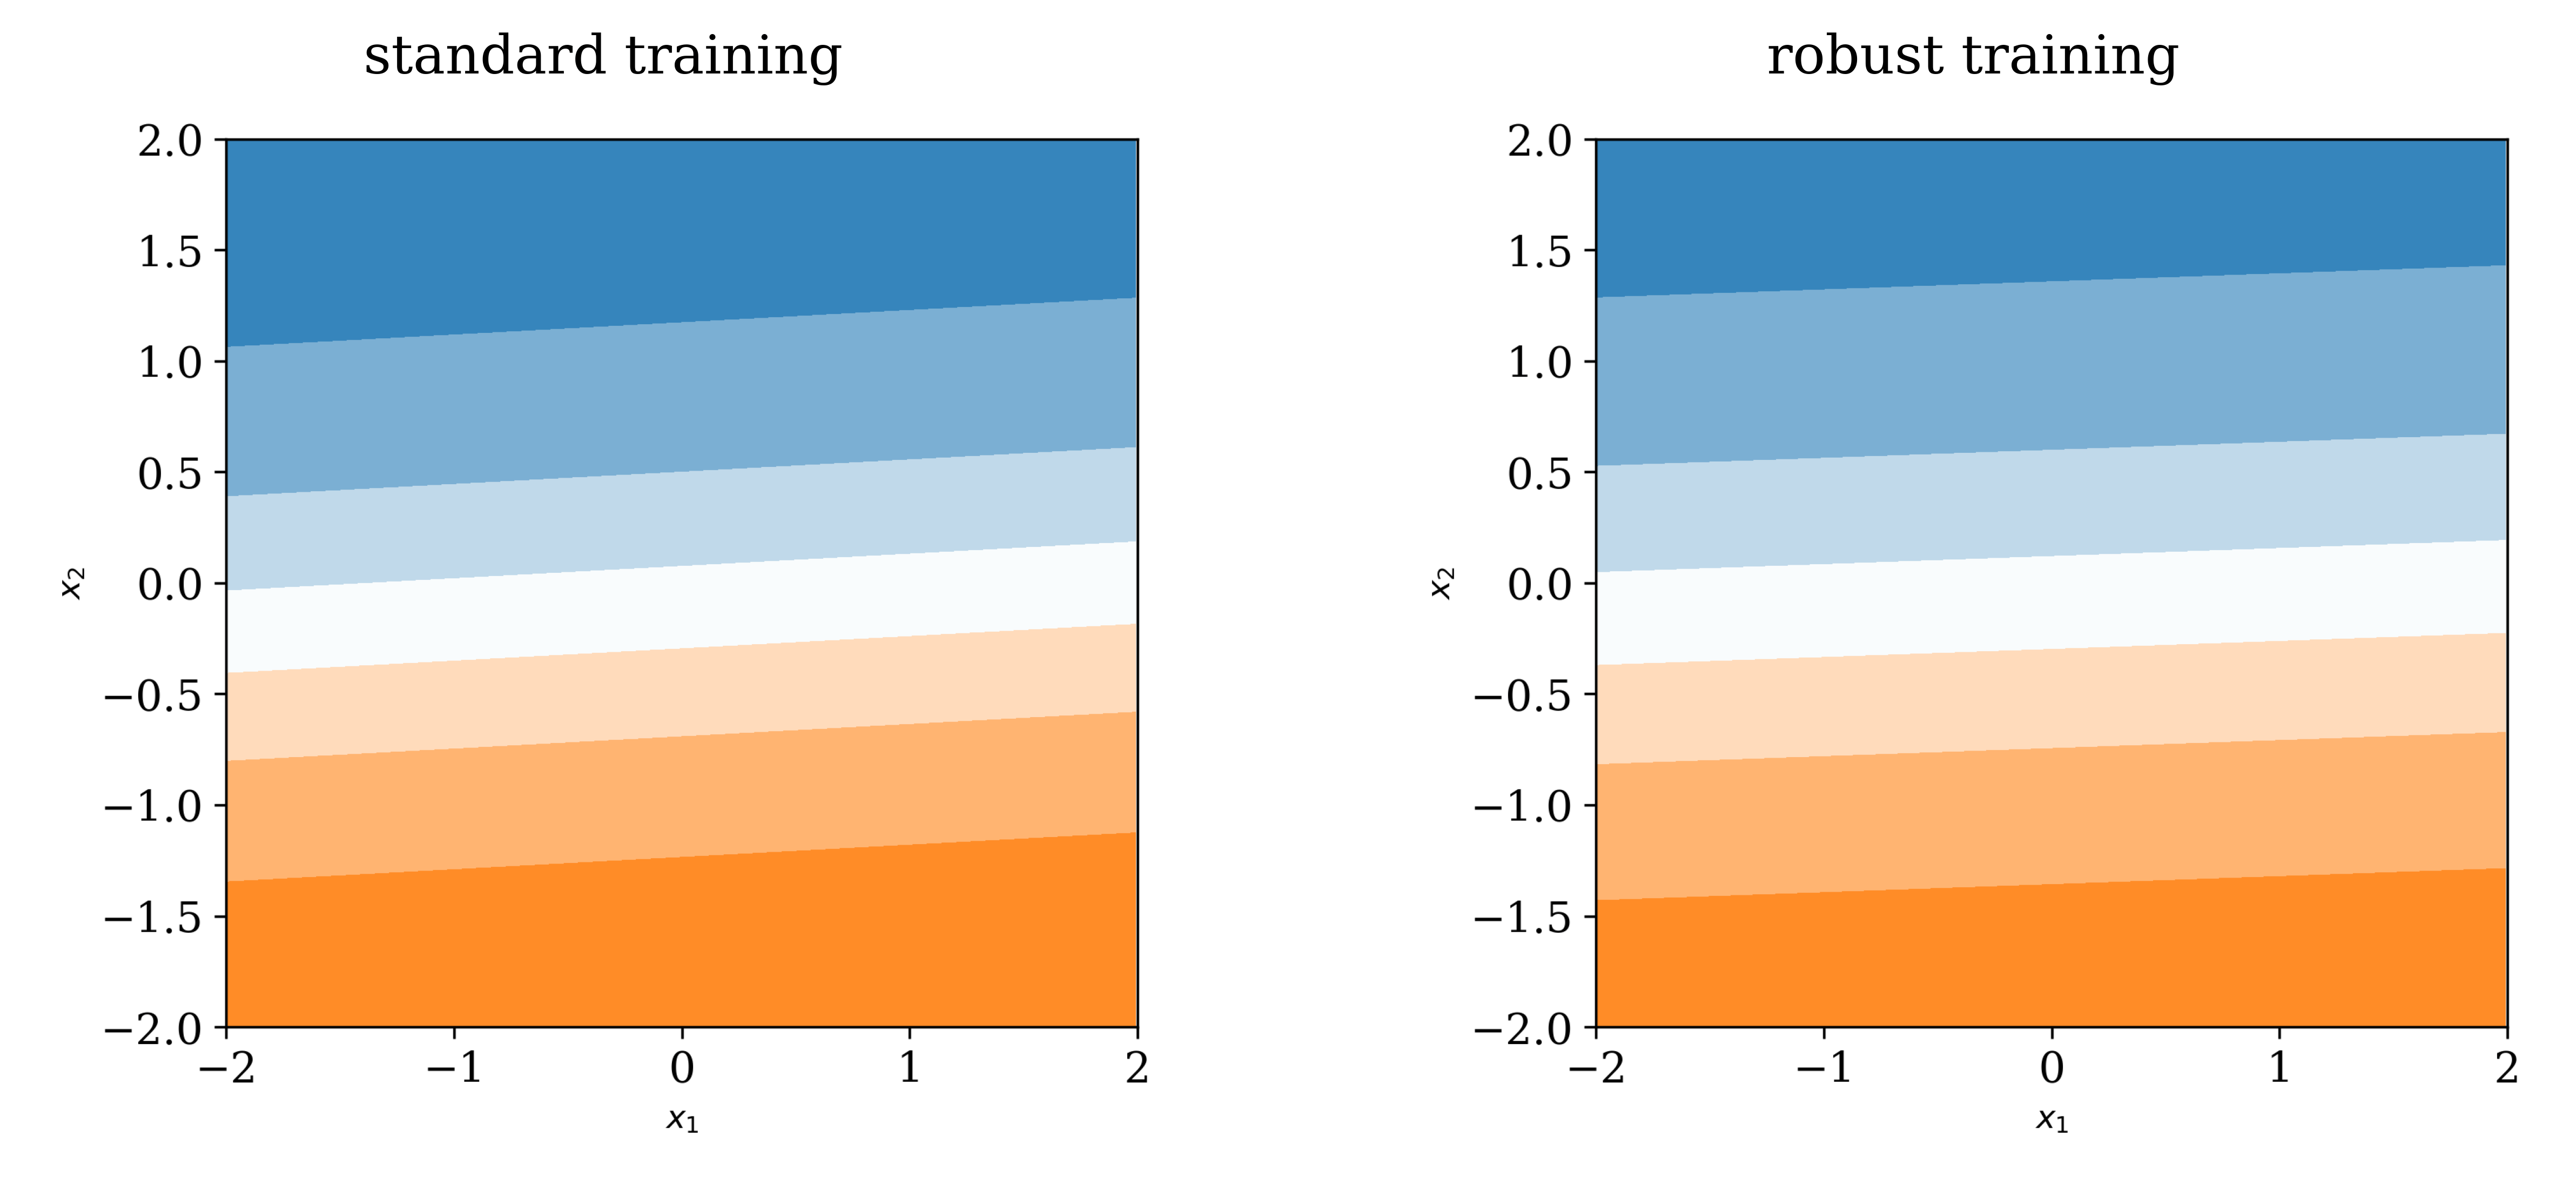

In [132]:
from IPython.display import Image
Image(filename="levelsets_comp.gif",  width = 800)

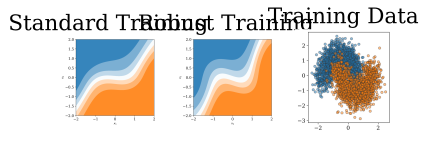

In [147]:
import imageio

plt.figure(dpi = 600)
plt.subplot(131)
levelsets = imageio.imread('levelsets.png')
plt.imshow(levelsets)
plt.title('Standard Training')
plt.axis('off')

plt.subplot(132)
levelsets_rob = imageio.imread('levelsets_rob.png')
plt.imshow(levelsets_rob)
plt.title('Robust Training')
plt.axis('off')

plt.subplot(133)
levelsets_rob = imageio.imread('trainingset.png')
plt.imshow(levelsets_rob)
plt.title('Training Data')
plt.axis('off')
plt.savefig('levelset_comp.png', bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
plt.show()

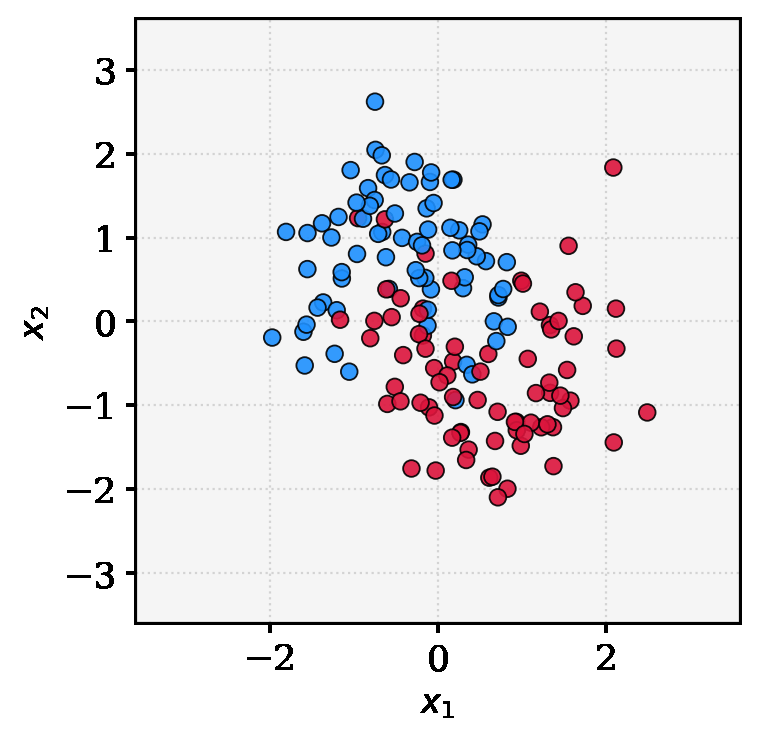

In [134]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif')
    break

#Display of the generated gif

from IPython.display import Image
Image(filename="trajectory.gif", retina = True)

In [135]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(rnode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif')
    break

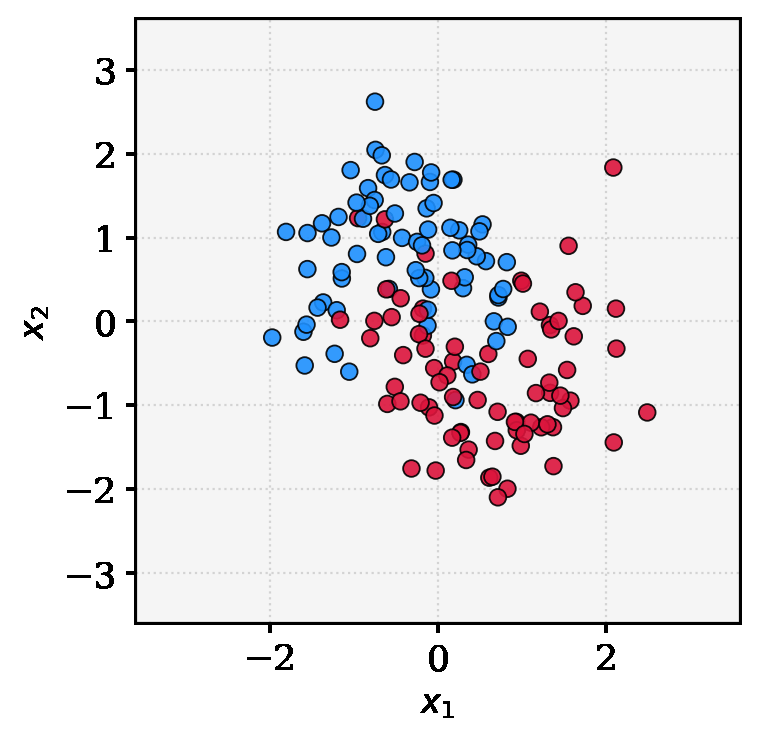

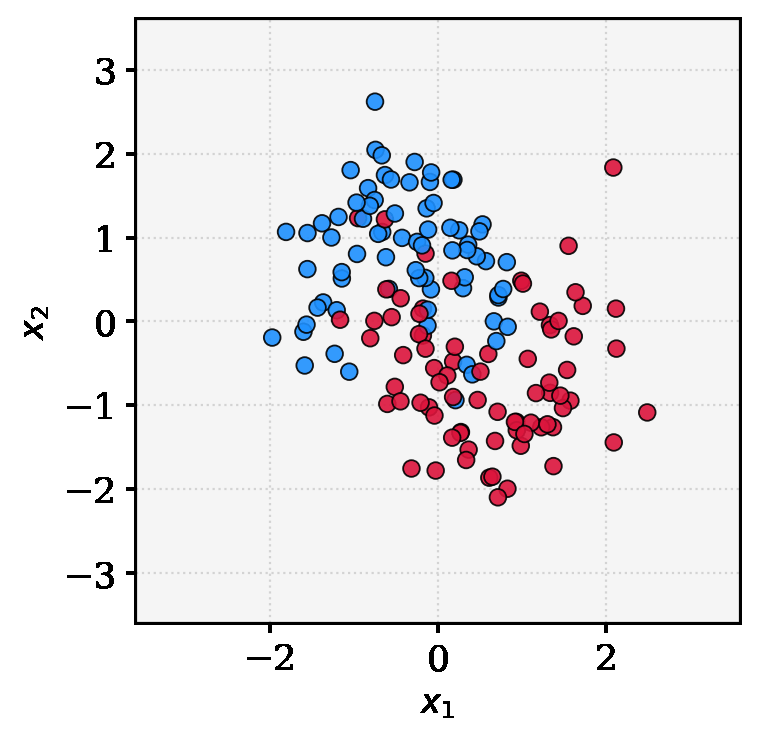

In [136]:
#Display of the generated gif

from IPython.display import Image
traj = Image(filename="trajectory.gif", retina = True)
rtraj = Image(filename="trajectory_db.gif", retina = True)
display(traj, rtraj)


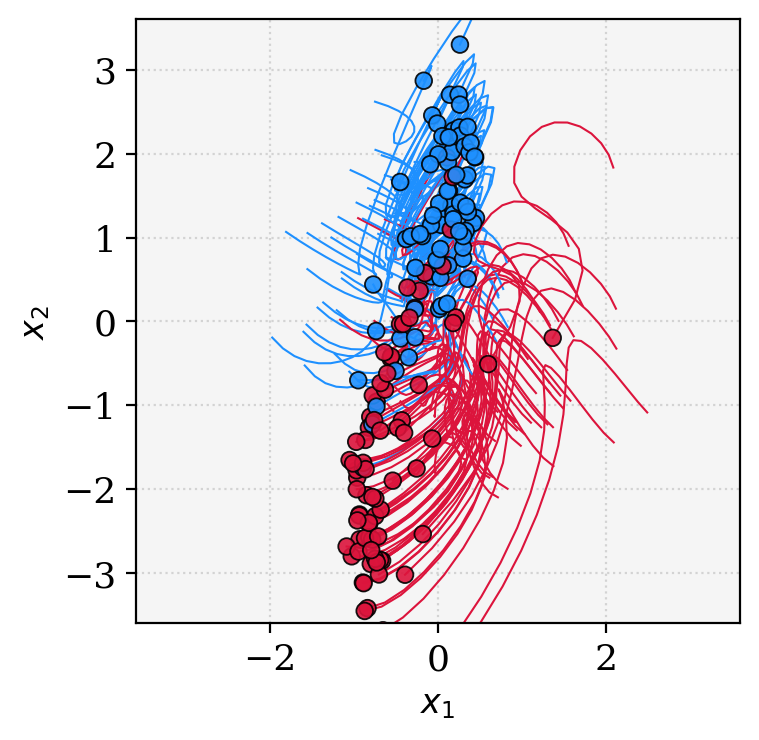

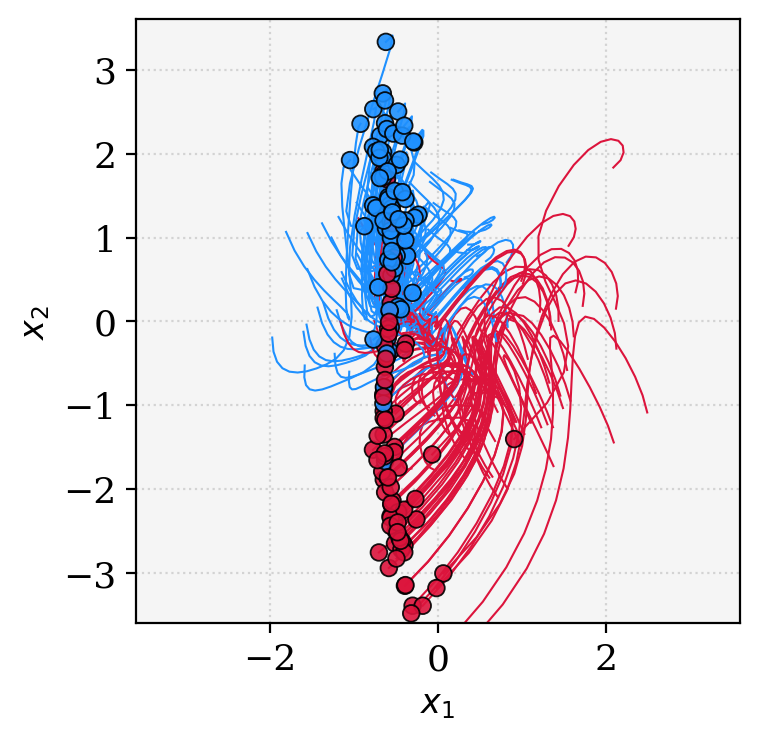

In [137]:
from IPython.display import Image
traj = Image(filename="trajectory19.png", retina = True)
rtraj = Image(filename="trajectory_db19.png", retina = True)
display(traj, rtraj)

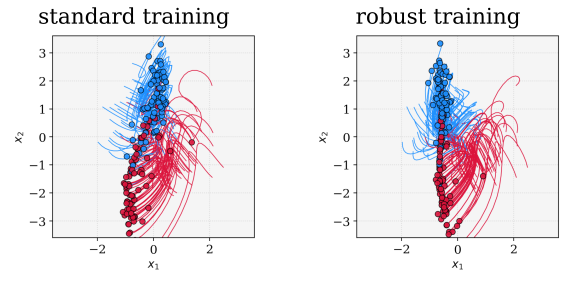

In [138]:
comparison_plot('trajectory19.png', 'standard training', 'trajectory_db19.png', 'robust training', 'traj_comp.png', show = True)


## Loss

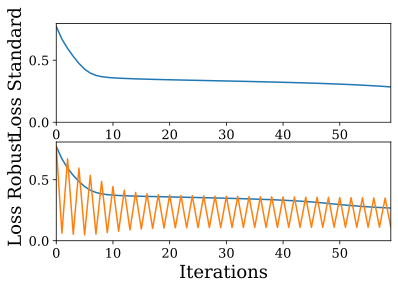

In [139]:
plt.figure(dpi = 300)
plt.subplot(211)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss Standard')

plt.subplot(212)
plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.plot(trainer_rnode.histories['epoch_loss_rob_history'])
# plt.plot([loss - rob for loss, rob in zip(trainer_rnode.histories['epoch_loss_history'],trainer_rnode.histories['epoch_loss_rob_history'])])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss Robust')
plt.savefig('loss_comp.png', bbox_inches='tight', dpi=600, format='png', facecolor = 'white')
plt.show()